In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import sklearn
from sklearn import preprocessing
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#!pip install h5py
from keras.models import load_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


In [ ]:
ita_complete = pd.read_csv("/content/drive/My Drive/Colab Notebooks/dpc-covid19-ita-andamento-nazionale.csv")
ita_complete.head(-10)

In [ ]:
data=ita_complete[["date","totale_positivi","deceduti"]]
data.rename(columns={'totale_positivi':'total_pos', 'deceduti':'deaths'}, inplace=True)
data.head(-10)

In [ ]:
ita_owid=pd.read_excel("/content/drive/My Drive/Colab Notebooks/ita_owid.xlsx", index_col=0)
ita_owid.head(-10)

In [ ]:
china_owid=pd.read_excel("/content/drive/My Drive/Colab Notebooks/china_owid.xlsx", index_col=0)
china_owid.head(-10)

In [ ]:
china_owid=pd.read_excel("/content/drive/My Drive/Colab Notebooks/china_owid_mod.xlsx", index_col=0)
china_owid.head(-10)

In [ ]:
print(round(data.total_pos.describe(),1))

count       133.0
mean      53218.9
std       36301.8
min         221.0
25%       20603.0
50%       47986.0
75%       88274.0
max      108257.0
Name: total_pos, dtype: float64


In [ ]:
date_time = pd.to_datetime(data.pop('date'), format='%Y-%m-%d')

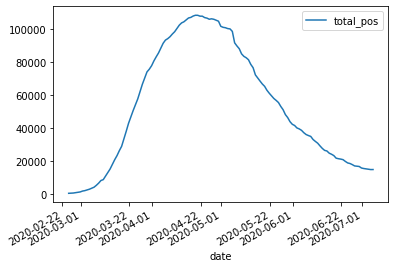

In [ ]:
plot_pos = ['total_pos']
plot_features = data[plot_pos]
plot_features.index = date_time
_=plot_features.plot(subplots=True)

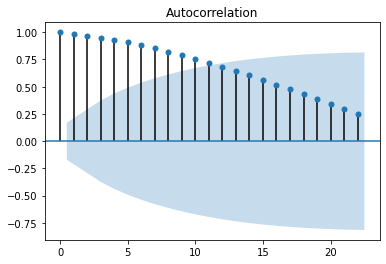

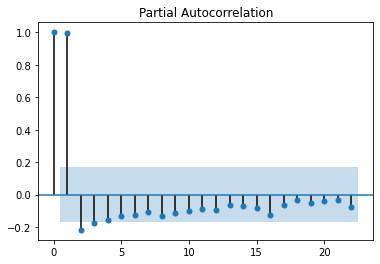

In [ ]:
# zoomed-in ACF plot of time series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

series = data.total_pos
plot_acf(series)
pyplot.show()

plot_pacf(series)
pyplot.show()


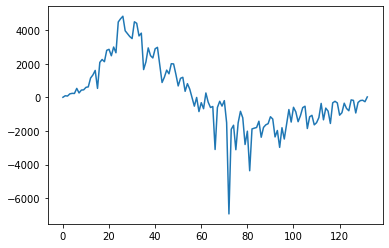

In [ ]:
pyplot.plot(ita_complete.variazione_totale_positivi)

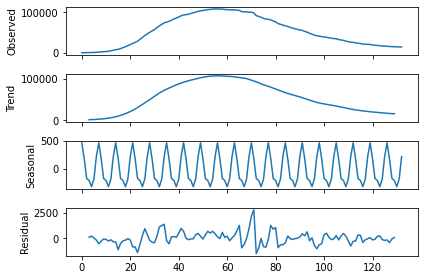

In [ ]:
# additive decomposition time series
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot

series = data.total_pos
result = seasonal_decompose(series, model='additive', freq=7)
result.plot()
pyplot.show()

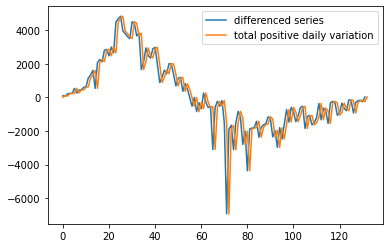

In [ ]:
# detrend a time series using differencing
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

X = data.total_pos
diff = list()
for i in range(1, len(X)):
  value = X[i] - X[i - 1]
  diff.append(value)

pyplot.plot(diff)
pyplot.plot(ita_complete.variazione_totale_positivi)
plt.legend(['differenced series', 'total positive daily variation'], loc='upper right')
pyplot.show()

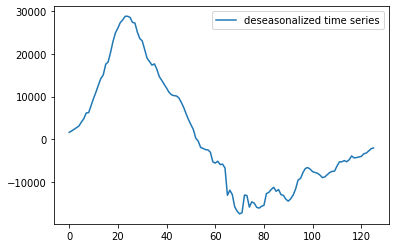

In [ ]:
# deseasonalize a time series using differencing

from pandas import read_csv
from matplotlib import pyplot

X = series
diff = list()
days_in_week = 7
for i in range(days_in_week, len(X)):
  value = X[i] - X[i - days_in_week]
  diff.append(value)

pyplot.plot(diff)
pyplot.legend(['deseasonalized time series'])
pyplot.show()

In [ ]:
#!pip install pmdarima
#from pmdarima import auto_arima

model = auto_arima(data.total_pos, start_p=1, max_p=10, start_q=1, max_q=10, start_P=0, max_P=10, start_Q=0, max_Q=10, D=0, max_D=7
                  ,trace=True, error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2156.818, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2186.446, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2169.691, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2155.640, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2156.619, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=2156.121, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2157.648, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.535 seconds


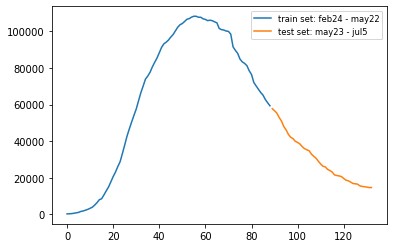

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data.total_pos, test_size=0.33, shuffle=False)
plt.plot(X_train, label="train set: feb24 - may22")
plt.plot(X_test, label="test set: may23 - jul5")
plt.legend(loc='upper right', fontsize='small')
plt.show()

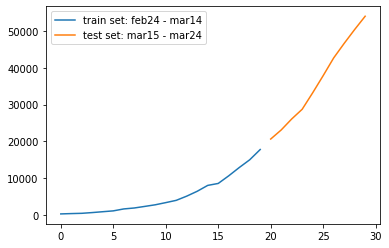

In [ ]:
from sklearn.model_selection import train_test_split

X_train_30, X_test_30 = train_test_split(data.total_pos[:30], test_size=0.33, shuffle=False)
plt.plot(X_train_30, label="train set: feb24 - mar14")
plt.plot(X_test_30, label="test set: mar15 - mar24")
plt.legend(loc='upper left')
plt.show()

In [ ]:
# define univariate time series - input sequence
raw_seq=array(data.total_pos)
#print(raw_seq.shape)

In [ ]:
# univariate mlp example
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# root mean squared error or rmse

#from math import sqrt
def RMSE(actual, predicted):
  return np.sqrt(keras.losses.MSE(actual, predicted))

In [ ]:
# difference dataset
def difference(data, order):
  return [data[i] - data[i - order] for i in range(order, len(data))]

diff=difference(data.total_pos, 1)
diff

In [ ]:


# transform to a supervised learning problem
# choose a number of time steps (lag)
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
#print(X.shape, y.shape)

# show each sample
for i in range(len(X)):
  print(X[i], y[i])

In [ ]:
for i in range(len(X)):
  print(X[i], y[i])

In [ ]:
raw_seq_itaowid=array(ita_owid.cases)

In [ ]:
# define univariate time series - input sequence
raw_seq_itaowid=array(ita_owid.cases)

# transform to a supervised learning problem
# choose a number of time steps (lag)
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq_itaowid, n_steps)
#print(X.shape, y.shape)

# show each sample
for i in range(len(X)):
  print(X[i], y[i])

In [ ]:
# define the MODEL
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mse")
# fit model
history=model.fit(X, y, epochs=2000, verbose=0)

# demonstrate prediction
#for x_input in X:
 #  x_input = x_input.reshape((1, n_steps))
  # print(x_input)
   #yhat = model.predict(x_input, verbose=1)
   #print(yhat)

In [ ]:
model.summary()

In [ ]:
history.history

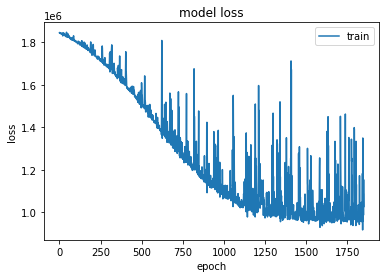

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][150:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
yhat=[]
for x_input in X:
   x_input = x_input.reshape((1, n_steps))
   yhat.append(model.predict(x_input))
yhat=np.array(yhat)
yhat=np.concatenate(yhat)

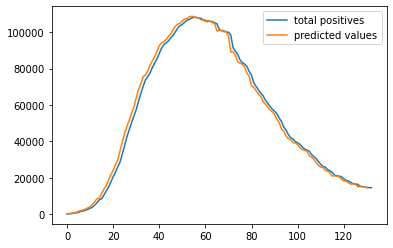

In [ ]:
plt.plot(data.total_pos, label="total positives")
plt.plot(yhat, label="predicted values")
plt.legend()

scaled values: 0 mean and variance 1

In [ ]:
raw_seq_scaled = preprocessing.scale(raw_seq)
#plt.plot(raw_seq_scaled)

In [ ]:
# choose a number of time steps (lag)
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq_scaled, n_steps)

In [ ]:
# choose a number of time steps (lag)
n_steps = 2
# split into samples
X, y = split_sequence(raw_seq_30, n_steps)

In [ ]:
#class LossHistory(keras.callbacks.Callback):
#    def on_train_begin(self, logs={}):
#        self.losses = []
#
#    def on_batch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/best_model.h5', monitor='loss', mode='min', save_best_only=True)

# define the model
model = Sequential()
model.add(Dense(7, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mse")

# fit the model
history=model.fit(X, y, epochs=4000, verbose=0, batch_size=64, callbacks=[es, mc], shuffle=False)


# load the saved model
saved_model = load_model('/content/drive/My Drive/Colab Notebooks/best_model.h5')

# evaluate the model
loss_model = saved_model.evaluate(X, y, verbose=1)

print('Loss, MSE: %.4f' % (loss_model))


#history=LossHistory()


# evaluate the model
#loss_model = model.evaluate(X, y, verbose=1)

#print('loss: %.4f' % (loss_model))


Epoch 03502: early stopping
5/5 [==============================] - 0s 2ms/step - loss: 875714.6875
Loss, MSE: 875714.6875


In [ ]:
len(history.history["loss"])

3502

In [ ]:
# load the saved model
saved_model = load_model('/content/drive/My Drive/Colab Notebooks/best_model.h5')

# evaluate the model
loss_model = saved_model.evaluate(X, y, verbose=0)
print('Loss, MSE: %.4f' % (loss_model))

Loss, MSE: 875714.6875


In [ ]:
saved_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 7)                 28        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 8         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


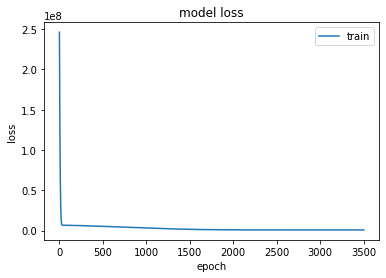

In [ ]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
yhat=[]
for x_input in X:
   x_input = x_input.reshape((1, n_steps))
   yhat.append(saved_model.predict(x_input))
yhat=np.array(yhat)
#yhat=np.concatenate(yhat)
#yhat=yhat.flatten()

Text(0.5, 0, 'Days from Feb 24 to July 5')

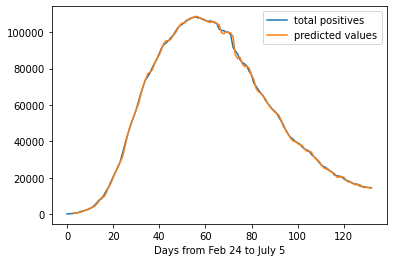

In [ ]:
plt.plot(data.total_pos, label="total positives")
plt.plot([None for i in raw_seq[:n_steps]] + [x for x in yhat], label="predicted values")
plt.legend()
plt.xlabel('Days from Feb 24 to July 5')

Text(0.5, 0, 'Days from April 4 to May 14')

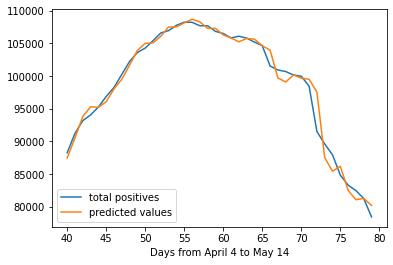

In [ ]:
plt.plot(data.total_pos[40:80], label="total positives")
plt.plot([None for i in raw_seq[:37+n_steps]] + [x for x in yhat][37:77], label="predicted values")
plt.legend()
plt.xlabel('Days from April 4 to May 14')

Text(0.5, 0, 'Days from Feb 24 to March 24')

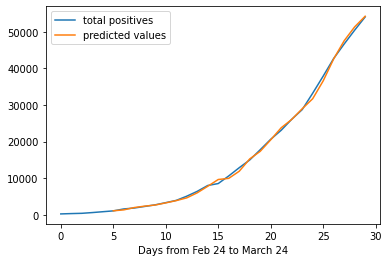

In [ ]:

plt.plot(data.total_pos[:30], label="total positives")
plt.plot([None for i in raw_seq[:n_steps]] + [x for x in yhat], label="predicted values")
plt.legend()
plt.xlabel('Days from Feb 24 to March 24')

[[58250.176]]


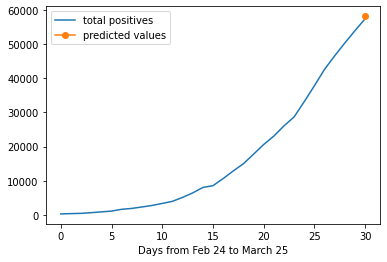

In [ ]:
x_input_prova = array(raw_seq_30[-n_steps:])
x_input_prova = x_input_prova.reshape((1, n_steps))
yhat_prova = saved_model.predict(x_input_prova, verbose=0)
print(yhat_prova)

plt.plot(raw_seq[0:31], label="total positives")
plt.plot([None for i in raw_seq_30] + [yhat_prova], label="predicted values", marker='o')
plt.plot([None for i in raw_seq_30] + [raw_seq[31]], marker='o')
plt.xlabel('Days from Feb 24 to March 25')
plt.legend()


In [ ]:
                                                                      #### evaluation metrics ###

expected=raw_seq[n_steps:]
yhat=yhat.flatten()
predictions = yhat

# forecast errors
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
#print('Forecast Errors:',forecast_errors)

# forecast bias (mean forecast error)
mean_forecast_error = np.mean(forecast_errors)
print('Mean Forecast Error (Bias) : %.4f' % mean_forecast_error)

# mean absolute error (MAE)
#mean_absolute_error = np.mean(np.abs(forecast_error))
mean_absolute_error = sklearn.metrics.mean_absolute_error(expected, predictions)
print("Mean Absolute Error (MAE) : %.4f"% mean_absolute_error)

# mean squared error (MSE)
mse = saved_model.evaluate(X, y, verbose=0)
print('Mean Squared Error (MSE): %.4f' % mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print('Root Mean Squared Error (RMSE) : %.4f' % rmse)

# R-squared
r2=r2_score(expected, predictions)
print('R-squared (R^2) : %.4f' % r2)

# Correlation r
r=np.corrcoef(predictions, expected)
print("Correlation : %.4f" % r[0,1])

# MAPE - Mean Absolute Percentage Error
def mean_absolute_percentage_error(expected, predictions): 
    expected, predictions = np.array(expected), np.array(predictions)
    return np.mean(np.abs((expected - predictions) / expected)) * 100
print("Mean Absolute Percentage Error (MAPE) : %.4f"% mean_absolute_percentage_error(expected, predictions))

Mean Forecast Error (Bias) : 83.2113
Mean Absolute Error (MAE) : 610.1248
Mean Squared Error (MSE): 875714.6875
Root Mean Squared Error (RMSE) : 935.7963
R-squared (R^2) : 0.9993
Correlation : 0.9997
Mean Absolute Percentage Error (MAPE) : 2.3382


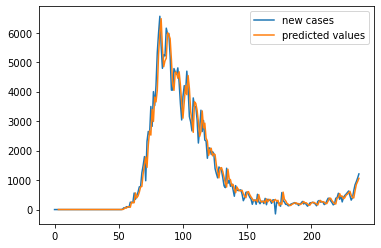

In [ ]:
plt.plot(raw_seq_itaowid, label="new cases")
plt.plot([None for i in raw_seq_itaowid[:n_steps]] + [x for x in yhat], label="predicted values")
plt.legend()

NORMALIZATION: RANGE 0-1

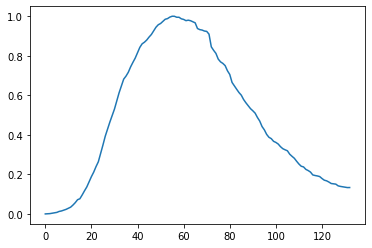

In [ ]:
raw_seq_minmax = (raw_seq-min(raw_seq))/(max(raw_seq)-min(raw_seq))
plt.plot(raw_seq_minmax)

In [ ]:
# choose a number of time steps (lag)
n_steps = 5
# split into samples
X, y = split_sequence(raw_seq_minmax, n_steps)

# es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
# eventualmente chiamarle in callbacks=[history, es, mc]
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mse")

# fit model
history=LossHistory()
model.fit(X, y, epochs=1000, verbose=0, callbacks=[history])

In [ ]:
min(history.losses)

1.6714879166102037e-05

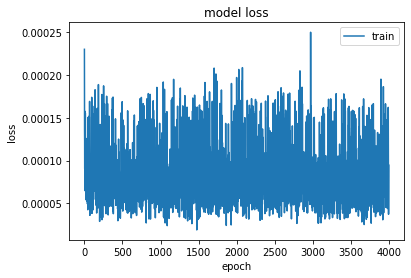

In [ ]:
# summarize history for loss
plt.plot(history.losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
yhat=[]
for x_input in X:
   x_input = x_input.reshape((1, n_steps))
   yhat.append(model.predict(x_input))
yhat=np.array(yhat)
yhat=np.concatenate(yhat)

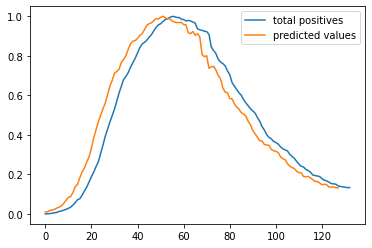

In [ ]:
# dovrei plottare valori originali -> inverse transform
plt.plot(raw_seq_minmax, label="total positives")
plt.plot(yhat, label="predicted values")
plt.legend()

In [ ]:
true=raw_seq_minmax[:128]
yhat=yhat.flatten()
r=np.corrcoef(true, yhat)
r

array([[1.        , 0.96546091],
       [0.96546091, 1.        ]])

FIRST 30 DAYS

In [ ]:
# FOR 30DAYS 24FEB - 24MAR

# choose a number of time steps (lag)
n_steps = 5

raw_seq_30=data.total_pos[:30]
# split into samples
X, y = split_sequence(raw_seq_30, n_steps)

In [ ]:

# define model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mse")

# fit model
history=LossHistory()
model.fit(X, y, epochs=2000, verbose=0, callbacks=[history])

# demonstrate prediction
#for x_input in X30:
#   x_input = x_input.reshape((1, n_steps))
 #  print(x_input)
  # yhat30 = model.predict(x_input, verbose=1)
   #print(yhat30)


In [ ]:
min(history.losses)

951771.125

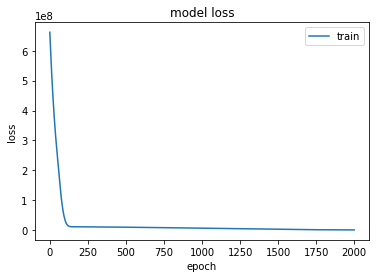

In [ ]:
# summarize history for loss
plt.plot(history.losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
yhat30=[]
for x_input in X:
   x_input = x_input.reshape((1, n_steps))
   yhat30.append(model.predict(x_input))
yhat30=np.array(yhat30)
yhat30=np.concatenate(yhat30)

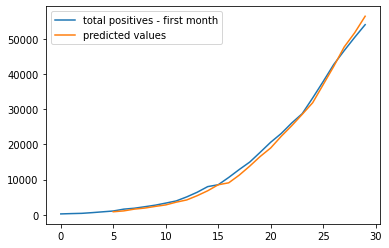

In [ ]:
plt.plot(raw_seq_30, label="total positives - first month")
plt.plot([None for i in raw_seq_30[:n_steps]] + [x for x in yhat], label="predicted values")

#plt.plot(yhat, label="predicted values")
plt.legend()

In [ ]:
#yhat30=yhat30.flatten()
RMSE(yhat, raw_seq_30[n_steps:])

1040.6930383162944

30 DAYS - SCALED VALUES, 0 MEAN AND VARIANCE 1

In [ ]:
# FOR 30DAYS 24FEB - 24MAR

raw_seq_30=raw_seq[:30]
raw_seq_scaled_30=preprocessing.scale(raw_seq_30)

#plt.plot(raw_seq_scaled_30)

In [ ]:
# choose a number of time steps (lag)
n_steps = 5

# split into samples
X, y = split_sequence(raw_seq_scaled_30, n_steps)

# define model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mse")

# fit model
history=LossHistory()
model.fit(X, y, epochs=2000, verbose=0, callbacks=[history])

In [ ]:
min(history.losses)

0.0005821661907248199

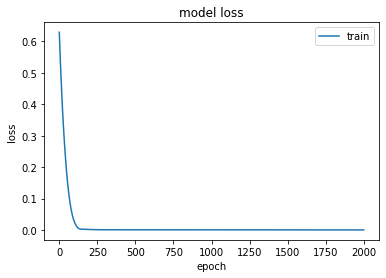

In [ ]:
# summarize history for loss
plt.plot(history.losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
yhat30=[]
for x_input in X:
   x_input = x_input.reshape((1, n_steps))
   yhat30.append(model.predict(x_input))
yhat30=np.array(yhat30)
yhat30=np.concatenate(yhat30)

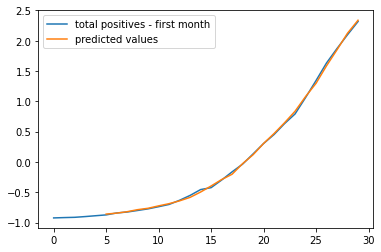

In [ ]:
plt.plot(raw_seq_scaled_30, label="total positives - first month")
plt.plot([None for i in data.total_pos[:n_steps]] + [x for x in yhat30], label='predicted values')

#plt.plot(yhat30, label="predicted values")
plt.legend()

In [ ]:
true=raw_seq_scaled_30[n_steps:]
yhat30=yhat30.flatten()
r=np.corrcoef(true, yhat30)
r

array([[1.        , 0.99970966],
       [0.99970966, 1.        ]])

In [ ]:
RMSE(yhat30, raw_seq_scaled_30[n_steps:])

0.024121987191611963

30 DAYS - NORMALIZED IN RANGE 0-1

In [ ]:
raw_seq_minmax_30 = (raw_seq_30-min(raw_seq_30))/(max(raw_seq_30)-min(raw_seq_30))
#plt.plot(raw_seq_minmax_30)
#plt.hist(raw_seq_minmax_30)

In [ ]:
# FOR 30DAYS 24FEB - 24MAR

# choose a number of time steps (lag)
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq_minmax_30, n_steps)

from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

# define model
model = Sequential()
model.add(Dense(16, activation='swish', input_dim=n_steps))
model.add(Dense(16, activation='swish', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

# fit model
history=LossHistory()
model.fit(X, y, epochs=2000, verbose=0, callbacks=[history])

In [ ]:
min(history.losses)

7.204261783044785e-05

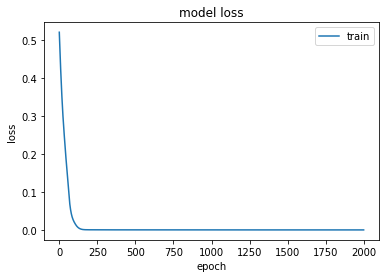

In [ ]:
# summarize history for loss
plt.plot(history.losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
yhat30=[]
for x_input in X:
   x_input = x_input.reshape((1, n_steps))
   yhat30.append(model.predict(x_input))
yhat30=np.array(yhat30)
yhat30=np.concatenate(yhat30)

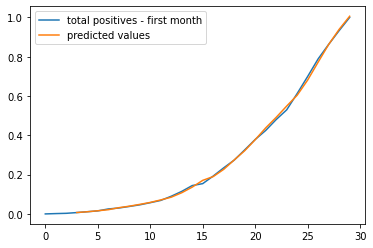

In [ ]:
plt.plot(raw_seq_minmax_30, label="total positives - first month")
plt.plot([None for i in data.total_pos[:n_steps]] + [x for x in yhat30], label="predicted values")

#plt.plot(yhat30, label="predicted values")
plt.legend()

In [ ]:
true=raw_seq_minmax_30[n_steps:]
yhat30=yhat30.flatten()
r=np.corrcoef(true, yhat30)
r

array([[1.       , 0.9996243],
       [0.9996243, 1.       ]])

Univariate multi-step vector-output mlp


In [ ]:
# univariate multi-step vector-output mlp example


# split a univariate sequence into samples
def split_sequence_multi(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# define input sequence
#raw_seq=data.total_pos

In [ ]:
# define input sequence 30 days
#raw_seq_30=data.total_pos[:30]


In [ ]:
#raw_seq_var=ita_complete.variazione_totale_positivi
#raw_seq_variation=ita_complete.variazione_totale_positivi[:37]
#raw_seq_variation_30=ita_complete.variazione_totale_positivi[:30]

In [ ]:
# define other input sequences

raw_seq_itaowid = ita_owid.cases

# dati china fino al 10 marzo
raw_seq_china_71=array(china_owid.cases[:71])

In [ ]:
# choose a number of time steps
n_steps_in, n_steps_out = 3, 7

# split into samples
X, y = split_sequence_multi(raw_seq_china_71, n_steps_in, n_steps_out)

# summarize the data
for i in range(len(X)):
  print(X[i], y[i])

In [ ]:
#class LossHistory(keras.callbacks.Callback):
#    def on_train_begin(self, logs={}):
#        self.losses = []
#
#    def on_batch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/best_model.h5', monitor='loss', mode='min', save_best_only=True)


# define model
model = Sequential()
model.add(Dense(12, activation='relu', input_dim=n_steps_in))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss="mse")

# fit model
#history=LossHistory()
history=model.fit(X, y, epochs=2000, verbose=0, callbacks=[es, mc], shuffle=False)

# evaluate the model
loss_model = model.evaluate(X, y, verbose=1)
print('loss: %.5f' % (loss_model))

2/2 [==============================] - 0s 4ms/step - loss: 418374.9688
loss: 418374.96875


In [ ]:
# load the saved model
saved_model = load_model('/content/drive/My Drive/Colab Notebooks/best_model.h5')

# evaluate the model
loss_model = saved_model.evaluate(X, y, verbose=0)
print('Loss, MSE: %.5f' % (loss_model))

from math import sqrt
print('Loss, RMSE: %.5f' % (sqrt(loss_model)))

Loss, MSE: 418374.96875
Loss, RMSE: 646.81912


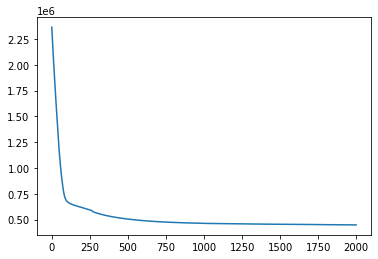

In [ ]:
plt.plot(history.history["loss"])

In [ ]:
saved_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_56 (Dense)             (None, 14)                238       
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# demonstrate prediction
x_input = array(raw_seq_variation[-n_steps_in:])
x_input = x_input.reshape((1, n_steps_in))
yhat = saved_model.predict(x_input, verbose=0)

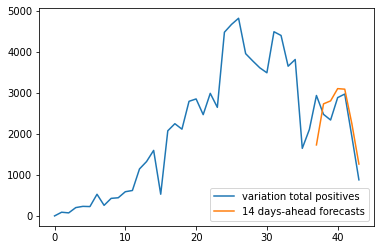

In [ ]:
plt.plot(raw_seq_var[:len(raw_seq_variation)+n_steps_out], label="variation total positives")
plt.plot([None for i in raw_seq_variation] + [x for x in yhat[0]], label="14 days-ahead forecasts")
plt.legend(loc="lower right")

In [ ]:
# demonstrate prediction
x_input = array(raw_seq_itaowid[-n_steps_in:])
x_input = x_input.reshape((1, n_steps_in))
yhat = saved_model.predict(x_input, verbose=0)

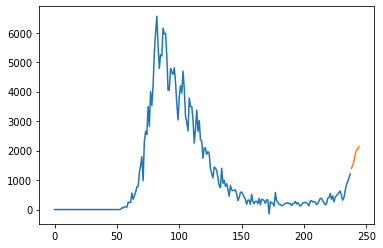

In [ ]:
plt.plot(raw_seq_itaowid, label="new cases")
plt.plot([None for i in raw_seq_itaowid] + [x for x in yhat[0]])

In [ ]:
# demonstrate prediction
x_input = array(raw_seq_itaowid[74:81])
x_input = x_input.reshape((1, n_steps_in))
yhat = model.predict(x_input, verbose=0)

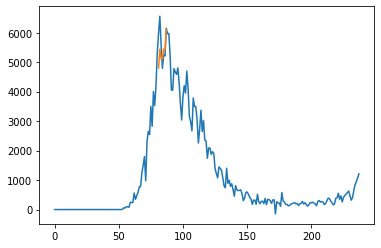

In [ ]:
plt.plot(raw_seq_itaowid, label="new cases")
plt.plot([None for i in raw_seq_itaowid[:81]] + [x for x in yhat[0]])

In [ ]:
# demonstrate prediction
x_input = array(raw_seq_itaowid_minmax[72:75])
x_input = x_input.reshape((1, n_steps_in))
yhat = saved_model.predict(x_input, verbose=0)

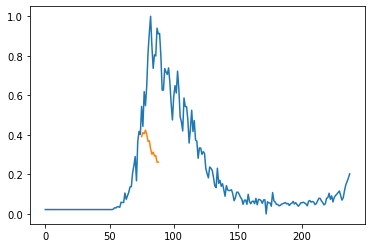

In [ ]:
plt.plot(raw_seq_itaowid_minmax, label="new cases")
plt.plot([None for i in raw_seq_itaowid_minmax[:75]] + [x for x in yhat[0]])

In [ ]:
# demonstrate prediction
x_input = array(raw_seq_china_75[35:42])
x_input = x_input.reshape((1, n_steps_in))
yhat = saved_model.predict(x_input, verbose=0)

In [ ]:
plt.plot(raw_seq_china_75, label="new cases - China")
plt.plot([None for i in raw_seq_china_75[:42]] + [x for x in yhat[0]], label="one-week ahead")
plt.legend()

NameError: ignored

In [ ]:
# demonstrate prediction
x_input = array(raw_seq_itaowid[74:81])
x_input = x_input.reshape((1, n_steps_in))
yhat = saved_model.predict(x_input, verbose=0)

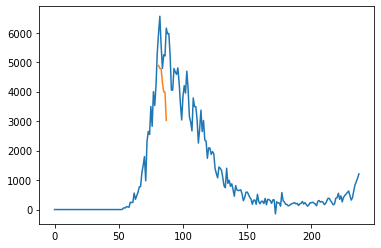

In [ ]:
plt.plot(raw_seq_itaowid, label="new cases - China")
plt.plot([None for i in raw_seq_itaowid[:81]] + [x for x in yhat[0]])

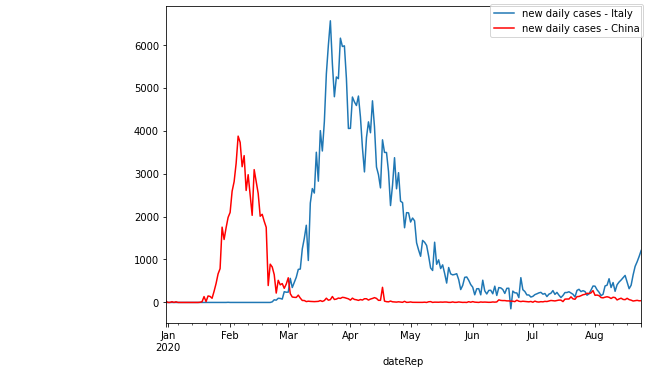

In [ ]:
#create figure
fig = plt.figure()
# add axes to the figure
ax = fig.add_axes([1,1,1.1,1.1])
ita_owid.cases.plot(label="new daily cases - Italy")
china_owid.cases.plot(label="new daily cases - China", color="red")
fig.legend()
